In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirpath, dirnames,filenames in os.walk('/kaggle/input'):
    print(f"there are {len(dirnames)} directoris and {len(filenames)} files in {dirpath}")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

there are 1 directoris and 0 files in /kaggle/input
there are 1 directoris and 0 files in /kaggle/input/ai-of-god-3
there are 2 directoris and 3 files in /kaggle/input/ai-of-god-3/Public_data
there are 0 directoris and 15010 files in /kaggle/input/ai-of-god-3/Public_data/train_images
there are 7 directoris and 0 files in /kaggle/input/ai-of-god-3/Public_data/test_images
there are 0 directoris and 24 files in /kaggle/input/ai-of-god-3/Public_data/test_images/Page_6
there are 0 directoris and 24 files in /kaggle/input/ai-of-god-3/Public_data/test_images/Page_4
there are 0 directoris and 24 files in /kaggle/input/ai-of-god-3/Public_data/test_images/Page_7
there are 0 directoris and 24 files in /kaggle/input/ai-of-god-3/Public_data/test_images/Page_3
there are 0 directoris and 24 files in /kaggle/input/ai-of-god-3/Public_data/test_images/Page_1
there are 0 directoris and 24 files in /kaggle/input/ai-of-god-3/Public_data/test_images/Page_2
there are 0 directoris and 24 files in /kaggle/inpu

In [2]:
import torch
import requests
import zipfile
import pathlib
from pathlib import Path

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
data_path = Path("/kaggle/input/ai-of-god-3/Public_data")

In [5]:
train_path = data_path/"train_images"
test_path = data_path/"test_images"
train_csv = data_path/"train.csv"

In [6]:
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from PIL import Image
import csv

In [7]:
from transformers import AutoTokenizer
class CustomImageDataset(Dataset):
    def __init__(self, root, csv_file, tokenizer=None, transform=None, mode="train"):
        self.root = root
        self.csv=csv_file
        self.paths = list(pathlib.Path(self.root).glob("*.png"))
        self.transform = transform
        self.tokenizer = tokenizer
        self.mode = mode
        self.labels = {'id':[],'transcription':[]}
        
        if mode == "train":
            with open(self.csv, mode='r') as file:
                csv_reader = csv.DictReader(file)
                for row in csv_reader:
                    self.labels['id'].append(row['unique Id'])
                    self.labels['transcription'].append(row['transcription'])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image_path = self.paths[index]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        if self.mode == "train":
            image_id = os.path.splitext(os.path.basename(image_path))[0]
            transcription = self.labels['transcription'][self.labels['id'].index(image_id)]
            encoding = self.tokenizer(transcription, max_length=32, padding="max_length", truncation=True, return_tensors="pt")
            input_ids = encoding["input_ids"].squeeze(0)
            attention_mask = encoding["attention_mask"].squeeze(0)
            return image, transcription,input_ids, attention_mask
        
        return image

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),         # Convert the image to a tensor
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],      # Normalize the image (adjust these values if needed for your encoder)
        std=[0.5, 0.5, 0.5]
    )
])

In [9]:
tokenizer_ = AutoTokenizer.from_pretrained("bert-base-uncased")

In [10]:
data = CustomImageDataset(
    root=train_path,
    csv_file=train_csv,
    tokenizer=tokenizer_,
    transform=data_transform,
    mode="train"
)

In [11]:
data[0]

(tensor([[[0.7098, 0.7255, 0.7176,  ..., 0.6314, 0.6784, 0.7647],
          [0.7098, 0.7255, 0.7176,  ..., 0.6314, 0.6784, 0.7647],
          [0.7098, 0.7255, 0.7176,  ..., 0.6235, 0.6784, 0.7647],
          ...,
          [0.7020, 0.7176, 0.7176,  ..., 0.7490, 0.7412, 0.7569],
          [0.7020, 0.7176, 0.7176,  ..., 0.7490, 0.7412, 0.7569],
          [0.7020, 0.7176, 0.7176,  ..., 0.7490, 0.7412, 0.7569]],
 
         [[0.7098, 0.7255, 0.7176,  ..., 0.6314, 0.6784, 0.7647],
          [0.7098, 0.7255, 0.7176,  ..., 0.6314, 0.6784, 0.7647],
          [0.7098, 0.7255, 0.7176,  ..., 0.6235, 0.6784, 0.7647],
          ...,
          [0.7020, 0.7176, 0.7176,  ..., 0.7490, 0.7412, 0.7569],
          [0.7020, 0.7176, 0.7176,  ..., 0.7490, 0.7412, 0.7569],
          [0.7020, 0.7176, 0.7176,  ..., 0.7490, 0.7412, 0.7569]],
 
         [[0.7098, 0.7255, 0.7176,  ..., 0.6314, 0.6784, 0.7647],
          [0.7098, 0.7255, 0.7176,  ..., 0.6314, 0.6784, 0.7647],
          [0.7098, 0.7255, 0.7176,  ...,

In [12]:
import pandas as pd
label_df = pd.DataFrame(data.labels)
label_df.head(n=10)

,id,transcription
0,Rodrigo_00006_00,Historia De España_Del
1,Rodrigo_00006_01,Arçobispo. Do Rodri_
2,Rodrigo_00006_02,go. Traducida En Ro_
3,Rodrigo_00006_03,mançe
4,Rodrigo_00008_00,E ste es el libro de la Cronica de es
5,Rodrigo_00008_01,"paña. Y cuenta, como fue poblada primeramente ..."
6,Rodrigo_00008_02,mo fue destruyda. & quien por este libro leyer...
7,Rodrigo_00008_03,"ra muchas Razones, en que puede Auer gran plazer"
8,Rodrigo_00008_04,¶ De lo que ymbio a dezir el arço
9,Rodrigo_00008_05,bispo Don Rodrigo Al Rey Don fernando de


In [13]:
import random
import matplotlib.pyplot as plt
import math
def display_random_images(dataset,n,seed=None):
  if n>10:
    n=10
  if seed:
    torch.manual_seed(seed)
  random_samples_idx = random.sample(range(len(dataset.paths)),n)
  plt.figure(figsize=(16,16))
  for i, id in enumerate(random_samples_idx):
    image, label ,_,_= dataset[id]
    plt.subplot(n,1,i+1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    title = f"class : {label} | \n size : {image.permute(1,2,0).shape}"
    plt.title(title,fontdict={'fontsize':8})


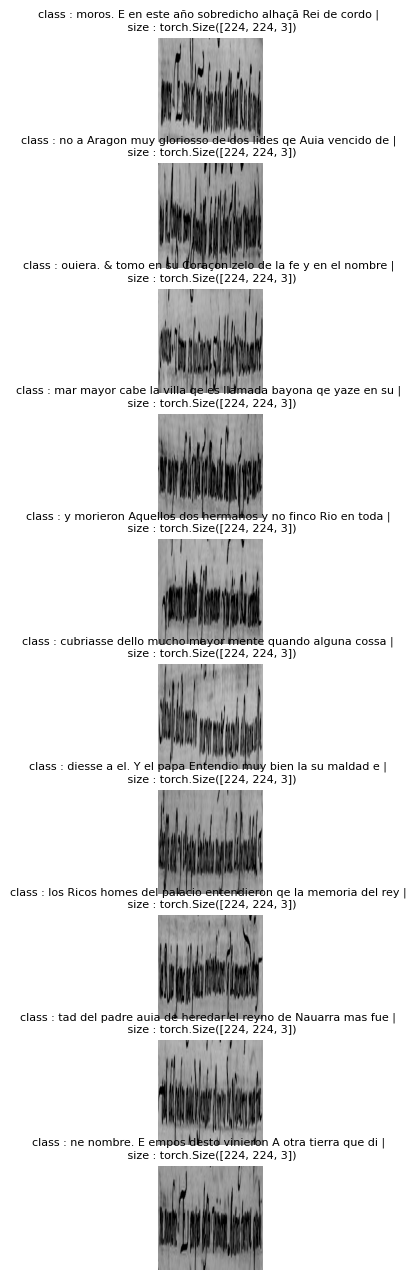

In [14]:
display_random_images(data,10,seed=42)

In [15]:
from torch.utils.data import random_split
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_data, test_data = random_split(data, [train_size, test_size])

In [16]:
from torch.utils.data import DataLoader
import os
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x799404f728f0>,
 <torch.utils.data.dataloader.DataLoader at 0x799404f708e0>)

In [17]:
from transformers import ViTModel, BartForCausalLM
import torch.nn as nn

class TrOCR(nn.Module):
    def __init__(self, 
                 vision_encoder="google/vit-base-patch16-224",
                 text_decoder="facebook/bart-base",
                 vocab_size=None):
        super(TrOCR, self).__init__()
        self.encoder = ViTModel.from_pretrained(vision_encoder)
        self.decoder = BartForCausalLM.from_pretrained(text_decoder)
        if vocab_size is not None:
            self.decoder.resize_token_embeddings(vocab_size)

    def forward(self, images, decoder_input_ids, decoder_attention_mask):
        encoder_outputs = self.encoder(images)
        encoder_hidden_states = encoder_outputs.last_hidden_state
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_hidden_states
        )
        logits = decoder_outputs.logits
        return logits


In [18]:
import numpy as np

def wer(reference, hypothesis):
    # Split the reference and hypothesis sentences into words
    reference_words = reference.split()
    hypothesis_words = hypothesis.split()

    # Create a matrix to store the distances
    d = np.zeros((len(reference_words) + 1, len(hypothesis_words) + 1), dtype=np.uint8)

    # Initialize the matrix
    for i in range(1, len(reference_words) + 1):
        d[i][0] = i
    for j in range(1, len(hypothesis_words) + 1):
        d[0][j] = j

    # Fill the matrix
    for i in range(1, len(reference_words) + 1):
        for j in range(1, len(hypothesis_words) + 1):
            if reference_words[i - 1] == hypothesis_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                d[i][j] = min(d[i - 1][j], d[i][j - 1], d[i - 1][j - 1]) + 1

    wer_value = d[len(reference_words)][len(hypothesis_words)] / len(reference_words)

    return wer_value

In [19]:
import torch
from tqdm.auto import tqdm

def train_step(model, data_loader, loss_fn, optimizer, tokenizer, device):
    model.train()
    train_loss, train_wer = 0, 0
    model.to(device)

    for batch,(images,labels, decoder_input_ids, attention_mask) in enumerate(data_loader):
        images,labels, decoder_input_ids, attention_mask = images.to(device),labels, decoder_input_ids.to(device), attention_mask.to(device)

        optimizer.zero_grad()

        logits = model(images, decoder_input_ids, attention_mask)
        loss = loss_fn(logits.view(-1, logits.size(-1)), decoder_input_ids.view(-1))
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        predicted_ids = torch.argmax(logits, dim=-1)
        predicted_texts = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

        batch_wer = wer(labels[0],predicted_texts[0])
        train_wer += batch_wer

    train_loss /= len(data_loader)
    train_wer /= len(data_loader)

    return train_loss, train_wer

In [20]:
def test_step(model, data_loader, loss_fn, tokenizer, device):
    model.eval()
    test_loss, test_wer = 0, 0
    model.to(device)

    with torch.no_grad():
        for batch,(images,labels, decoder_input_ids, attention_mask) in enumerate(data_loader):
            images,labels, decoder_input_ids, attention_mask = images.to(device),labels, decoder_input_ids.to(device), attention_mask.to(device)

            logits = model(images, decoder_input_ids, attention_mask)
            loss = loss_fn(logits.view(-1, logits.size(-1)), decoder_input_ids.view(-1))
            test_loss += loss.item()

            predicted_ids = torch.argmax(logits, dim=-1)
            predicted_texts = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

            batch_wer = wer(labels[0],predicted_texts[0])
            test_wer += batch_wer

    test_loss /= len(data_loader)
    test_wer /= len(data_loader)

    return test_loss, test_wer

In [21]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, tokenizer, epochs, device):
    results = {
        "train_loss": [],
        "train_wer": [],
        "test_loss": [],
        "test_wer": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_wer = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            tokenizer=tokenizer,
            device=device
        )

        test_loss, test_wer = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            tokenizer=tokenizer,
            device=device
        )

        print(
            f"Epoch: {epoch + 1} | train_loss: {train_loss:.4f} | train_wer: {train_wer:.4f} | "
            f"test_loss: {test_loss:.4f} | test_wer: {test_wer:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_wer"].append(train_wer)
        results["test_loss"].append(test_loss)
        results["test_wer"].append(test_wer)

    return results

In [22]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [23]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

vocab_size = len(tokenizer_)

model = TrOCR(vision_encoder="google/vit-base-patch16-224",
              text_decoder="facebook/bart-base",
              vocab_size=vocab_size)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

loss_fn = CrossEntropyLoss()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['decoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
torch.manual_seed(42)
epochs = 5

from timeit import default_timer as timer
start_time = timer()

results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    tokenizer=tokenizer_,  # Pass the tokenizer for decoding
    epochs=epochs,
    device=device
)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 4.5724 | train_wer: 1.0048 | test_loss: 6.7317 | test_wer: 1.0000
